In [296]:
import time

import diffrax
import equinox as eqx
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import jax.lax as lax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optax
from functools import partial
import pickle

import sys, os
sys.path.append(os.path.join(os.getcwd(), "../"))
from src.data.data_reader import DataReader

key_number = 8

def key():
    global key_number
    key_number += 1
    return jax.random.PRNGKey(key_number)

In [297]:
def get_data(processed_file):
    with open(processed_file, 'rb') as f:
        sequences = pickle.load(f)
    
    sorted_train_data = []
    for idx, (ts, xs, ts_eval, ys_eval) in enumerate(sequences):
        t0 = ts[0]
        t_ms = (ts - t0) / 1e11
        te_ms = (ts_eval - t0) / 1e11

        if len(t_ms) != len(xs):
            print(f"Warning: Inconsistent lengths in sequence {idx}: len(t_ms)={len(t_ms)}, len(xs)={len(xs)}")
            continue  

        if len(te_ms) != len(ys_eval):
            print(f"Warning: Inconsistent lengths in ts_eval and ys_eval in sequence {idx}")
            continue 
        
        sorted_indices = np.argsort(t_ms)
        t_ms = t_ms[sorted_indices]
        xs = xs[sorted_indices]

        sorted_indices = np.argsort(te_ms)
        te_ms = te_ms[sorted_indices]
        ys_eval = ys_eval[sorted_indices]

        xs0 = xs[0][0]

        xs = xs - xs0
        ys_eval = ys_eval - xs0

        # Keep data as arrays
        sorted_train_data.append((t_ms, xs, te_ms, ys_eval))


    if not sorted_train_data:
        raise ValueError("No valid sequences found in the processed data.")

    return sorted_train_data

def dataloader(sequences, batch_size, subset_size, *, key):
    dataset_size = len(sequences[0])
    assert all(len(seq) == dataset_size for seq in sequences)
    indices = np.arange(dataset_size)

    while True:
        subset_perm = np.random.choice(indices, size=subset_size, replace=False)

        start = 0
        end = batch_size

        while start < subset_size:
            batch_perm = subset_perm[start:end]
            # Ensure data remains as arrays
            batch = [ [seq[i] for i in batch_perm] for seq in sequences ]
            yield batch
            start = end
            end = start + batch_size

In [298]:
data = get_data("../data/processed/Visa_2024-09-06_1ms_limit_large.pkl")

In [299]:
print(len(data))
print(len(data[0]))
print(len(data[0][0]))
print(len(data[0][1]))
print(len(data[0][2]))
print(len(data[0][3]))

print(len(data[1]))
print(len(data[1][0]))
print(len(data[1][1]))
print(len(data[1][2]))
print(len(data[1][3]))

print(len(data[0][1][0]))
print(type(data[0][1][0]))

# 

8192
4
52
52
12
12
4
52
52
12
12
6
<class 'numpy.ndarray'>


In [300]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP
    data_size: int
    hidden_size: int

    def __init__(self, data_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.data_size = data_size
        self.hidden_size = hidden_size
        self.mlp = eqx.nn.MLP(
            in_size=hidden_size,
            out_size=hidden_size * data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            # Note the use of a tanh final activation function. This is important to
            # stop the model blowing up. (Just like how GRUs and LSTMs constrain the
            # rate of change of their hidden states.)
            final_activation=jnn.tanh,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y).reshape(self.hidden_size, self.data_size)
    

In [301]:
class NeuralCDE(eqx.Module):
    initial: eqx.nn.Linear
    func: Func
    hidden_to_pred: eqx.nn.MLP

    def __init__(self, data_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        ikey, fkey, lkey = jr.split(key, 3)
        self.initial = eqx.nn.Linear(data_size + 1, hidden_size, key=ikey)
        self.func = Func(data_size + 1, hidden_size, width_size, depth, key=fkey)
        self.hidden_to_pred = eqx.nn.MLP(hidden_size, 1, width_size, depth, key=lkey) 

    def predict_batch(self, ts_batch, x_batch, ts_eval_batch):
        # ts_batch = [ts.reshape(-1, 1) for ts in ts_batch]
        predictions = jax.vmap(self.predict, in_axes=(0, 0, 0))(ts_batch, x_batch, ts_eval_batch)
        # predictions = []
        # for ts, x, ts_eval in zip(ts_batch, x_batch, ts_eval_batch):
        #     predictions.append(self.predict(ts, x, ts_eval))

        return jnp.array(predictions)

    def predict(self, ts, x, ts_eval):
        ts, x = diffrax.rectilinear_interpolation(ts, x)
        data = jnp.hstack([ts.reshape(-1, 1), x])
        data = jnp.array(data)

        control = diffrax.LinearInterpolation(ts, data)

        term = diffrax.ControlTerm(self.func, control).to_ode()
        solver = diffrax.Tsit5()
        dt0 = None
        y0 = self.initial(control.evaluate(ts[0])) 
        saveat = diffrax.SaveAt(ts=ts_eval)
        
        solution = diffrax.diffeqsolve(
            term,
            solver,
            ts[0],
            ts[-1],
            dt0,
            y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-2, atol=1e-1, jump_ts=ts),
            saveat=saveat,
            max_steps = 65536
        )
        
        prediction = jax.vmap(lambda y: self.hidden_to_pred(y)[0])(solution.ys)

        return prediction
    
    def compute_loss_batch(self, ts_batch, x_batch, ts_eval_batch, y_true_batch):
        y_pred = self.predict_batch(ts_batch, x_batch, ts_eval_batch)
        return jnp.mean((y_pred - y_true_batch) ** 2)
    
    def compute_loss(self, ts, x, ts_eval, y_true):
        y_pred = self.predict(ts, x, ts_eval)
        print(y_pred)
        return jnp.mean((y_pred - y_true) ** 2)

In [302]:
data_size = 6
hidden_size = 1
width_size = 4
depth = 2

model = NeuralCDE(data_size, hidden_size, width_size, depth, key=key())

In [303]:
t, x, t_eval, y_eval = data[0]
# t_batch, x_batch, t_eval_batch, y_eval_batch = data[0:8, 0], data[0:8, 1], data[0:8, 2], data[0:8, 3]

# print(type(t_batch[0]))
# print(type(x_batch[0]))
# print(type(t_eval_batch[0]))
# print(type(y_eval_batch[0]))


# print(data[0:8])
# print(len(x))
# print(data[5][0][-2:])
data[5][0][-1] = 2585
t_batch, x_batch, t_eval_batch, y_eval_batch = map(np.array, zip(*data[0:8]))
# t_batch[5][0][-1] = 2585
# print(len(t_batch[0]))

# for i in range(10):
#     t, x, t_eval, y_eval = data[i]
#     # if i == 5:
#     #     t[-1] = 2585
#     try:
#         model.compute_loss(t, x, t_eval, y_eval)
#     except:
#         print("her etresdt easgrs")
#         print(t)
model.compute_loss_batch(t_batch, x_batch, t_eval_batch, y_eval_batch)
# model.compute_loss(data[0:8])

Array(543.18677, dtype=float32)

In [306]:
from equinox import EquinoxRuntimeError

def train(model, train_data, optimizer, steps, batch_size, seq_length, eval_point_ratio, key, subset_size, patience=500, plot_every=500):
    opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))
    losses = []
    best_loss = float('inf')
    best_model = model
    last_best_step = 0
    step_times = []

    @eqx.filter_value_and_grad
    def loss(model, ts, xs, ts_test, y_true):
        return model.compute_loss_batch(ts, xs, ts_test, y_true) 

    @eqx.filter_jit
    def make_step(model, opt_state, ts, xs, ts_test, y_true):
        value, grads = loss(model, ts, xs, ts_test, y_true)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return value, model, opt_state
    
    num_params = sum(p.size for p in jax.tree_util.tree_leaves(eqx.filter(model, eqx.is_inexact_array)))
    num_train_points = len(train_data) * seq_length * eval_point_ratio

    print("-" * 60)
    print(f"Number of parameters: {num_params}")
    print(f"Number of data points: {int(num_train_points)}")
    print("-" * 60)

    ts, xs, ts_eval, y_test = zip(*train_data)

    arrays = (jnp.array(ts), jnp.array(xs), jnp.array(ts_eval), jnp.array(y_test))
    data_gen = dataloader(arrays, batch_size, subset_size=subset_size, key=key)

    train_count = 0

    for step in range(steps):
        start_time = time.time()

        # Get the next batch from the dataloader
        ts_batch, xs_batch, ts_test_batch, y_true_batch = next(data_gen)
        ts_batch, xs_batch, ts_test_batch, y_true_batch = jnp.array(ts_batch), jnp.array(xs_batch), jnp.array(ts_test_batch), jnp.array(y_true_batch)
        # ts_batch, xs_batch, ts_test_batch, y_true_batch = map(np.array, zip(*data[batch_num*batch_size: batch_num*(batch_size + 1)]))

        # Perform a training step
        train_count += 1
        loss_value, model, opt_state = make_step(model, opt_state, ts_batch, xs_batch, ts_test_batch, y_true_batch)
        losses.append(loss_value)
    

        step_time = time.time() - start_time
        step_times.append(step_time)
        if len(step_times) > 100:
            step_times.pop(0)

        if loss_value < best_loss:
            best_loss = loss_value
            best_model = model
            last_best_step = step

        if step % 100 == 0:
            avg_step_time = sum(step_times) / len(step_times) if step_times else 0
            estimated_time_remaining = avg_step_time * (steps - step - 1)
            if step == 0:
                print(f"Step {step}, Loss: {loss_value:.4f}, Best Loss: {best_loss:.4f}, Estimated Time Remaining: -- ")
            else:
                print(f"Step {step}, Loss: {loss_value:.4f}, Best Loss: {best_loss:.4f}, Estimated Time Remaining: {estimated_time_remaining / 60:.2f} minutes")

        if step % plot_every == 0:
            _, subkey = jr.split(key)
            random_index = jr.randint(subkey, (1,), 0, batch_size).item()
            plt.figure(figsize=(4, 3))
            plt.plot(ts_test_batch[random_index], y_true_batch[random_index], label='Actual', marker='o')
            y_pred = best_model.predict(ts_batch[random_index], xs_batch[random_index], ts_test_batch[random_index])
            y_pred = y_pred.squeeze()
            plt.plot(ts_test_batch[random_index], y_pred, label='Predicted', marker='x')
            print(y_pred)
            plt.xlabel('Time (ts_test)')
            plt.ylabel('Y values')
            plt.title(f'Training Sequence at Step {step}: Actual vs Predicted Y over Time')
            plt.legend()
            plt.grid(True)
            plt.show()

        if step - last_best_step >= patience:
            print(f"Stopping early at step {step}, no improvement for {patience} steps.")
            return best_model

    plt.figure(figsize=(10, 6))
    plt.plot(np.log(losses), label="Training Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"train count: {train_count}")

    return best_model

------------------------------------------------------------
Number of parameters: 661
Number of data points: 98304
------------------------------------------------------------
Step 0, Loss: 44.4736, Best Loss: 44.4736, Estimated Time Remaining: -- 
[7782.821  7782.9736 7783.0776 7783.093  7783.097  7783.1543 7783.282
 7783.285  7783.3516 7783.4624 7783.768  7783.8457]


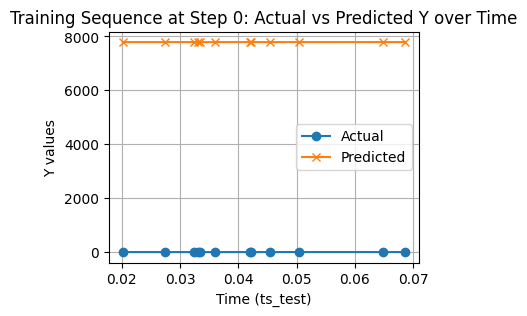

Step 100, Loss: 11.7613, Best Loss: 0.0898, Estimated Time Remaining: 52.66 minutes
Step 200, Loss: 12.6350, Best Loss: 0.0898, Estimated Time Remaining: 51.49 minutes
Step 300, Loss: 13.6358, Best Loss: 0.0898, Estimated Time Remaining: 53.30 minutes
Step 400, Loss: 11.4745, Best Loss: 0.0898, Estimated Time Remaining: 52.23 minutes
Step 500, Loss: 12.3576, Best Loss: 0.0898, Estimated Time Remaining: 51.82 minutes
Step 600, Loss: 12.1988, Best Loss: 0.0898, Estimated Time Remaining: 52.04 minutes
Step 700, Loss: 13.5022, Best Loss: 0.0898, Estimated Time Remaining: 51.36 minutes
Step 800, Loss: 13.1631, Best Loss: 0.0898, Estimated Time Remaining: 51.48 minutes
Step 900, Loss: 11.0812, Best Loss: 0.0898, Estimated Time Remaining: 55.05 minutes
Step 1000, Loss: 12.3374, Best Loss: 0.0898, Estimated Time Remaining: 54.89 minutes
[0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705
 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705]


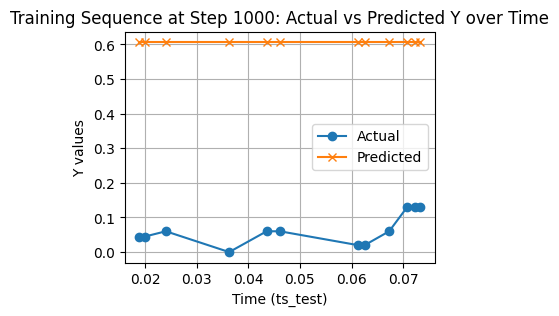

Step 1100, Loss: 13.1769, Best Loss: 0.0898, Estimated Time Remaining: 51.05 minutes
Step 1200, Loss: 12.2271, Best Loss: 0.0898, Estimated Time Remaining: 50.76 minutes
Step 1300, Loss: 13.0170, Best Loss: 0.0898, Estimated Time Remaining: 50.73 minutes
Step 1400, Loss: 12.1843, Best Loss: 0.0898, Estimated Time Remaining: 50.51 minutes
Step 1500, Loss: 13.5168, Best Loss: 0.0898, Estimated Time Remaining: 50.69 minutes
Step 1600, Loss: 12.5026, Best Loss: 0.0898, Estimated Time Remaining: 50.44 minutes
Step 1700, Loss: 11.2916, Best Loss: 0.0898, Estimated Time Remaining: 50.74 minutes
Step 1800, Loss: 12.5466, Best Loss: 0.0898, Estimated Time Remaining: 50.78 minutes
Step 1900, Loss: 13.0762, Best Loss: 0.0898, Estimated Time Remaining: 50.20 minutes
Step 2000, Loss: 12.9715, Best Loss: 0.0898, Estimated Time Remaining: 50.37 minutes
[0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705
 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705]


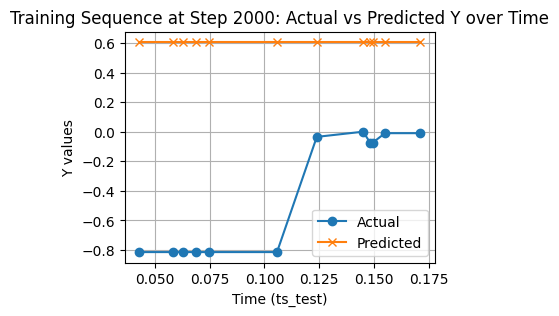

Step 2100, Loss: 12.3162, Best Loss: 0.0898, Estimated Time Remaining: 51.34 minutes
Step 2200, Loss: 12.2600, Best Loss: 0.0898, Estimated Time Remaining: 52.17 minutes
Step 2300, Loss: 12.2397, Best Loss: 0.0898, Estimated Time Remaining: 50.35 minutes
Step 2400, Loss: 12.2625, Best Loss: 0.0898, Estimated Time Remaining: 50.29 minutes
Step 2500, Loss: 12.3026, Best Loss: 0.0898, Estimated Time Remaining: 49.94 minutes
Step 2600, Loss: 12.4308, Best Loss: 0.0898, Estimated Time Remaining: 49.86 minutes
Step 2700, Loss: 11.9866, Best Loss: 0.0898, Estimated Time Remaining: 50.36 minutes
Step 2800, Loss: 12.3430, Best Loss: 0.0898, Estimated Time Remaining: 49.85 minutes
Step 2900, Loss: 11.7383, Best Loss: 0.0898, Estimated Time Remaining: 49.55 minutes
Step 3000, Loss: 12.2780, Best Loss: 0.0898, Estimated Time Remaining: 49.62 minutes
[0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705
 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705]


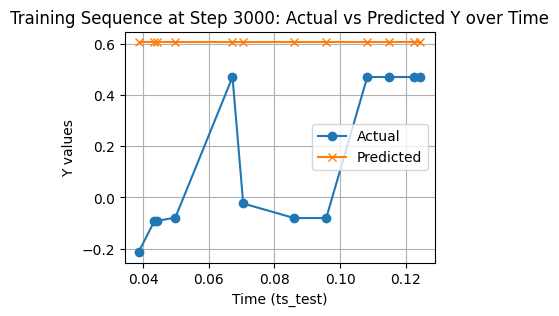

Step 3100, Loss: 12.1499, Best Loss: 0.0898, Estimated Time Remaining: 50.81 minutes
Step 3200, Loss: 13.3272, Best Loss: 0.0898, Estimated Time Remaining: 49.75 minutes
Step 3300, Loss: 12.6565, Best Loss: 0.0898, Estimated Time Remaining: 49.77 minutes
Step 3400, Loss: 11.8598, Best Loss: 0.0898, Estimated Time Remaining: 50.14 minutes
Step 3500, Loss: 12.9161, Best Loss: 0.0898, Estimated Time Remaining: 49.84 minutes
Step 3600, Loss: 12.4530, Best Loss: 0.0898, Estimated Time Remaining: 49.75 minutes
Step 3700, Loss: 11.8159, Best Loss: 0.0898, Estimated Time Remaining: 49.67 minutes
Step 3800, Loss: 11.5601, Best Loss: 0.0898, Estimated Time Remaining: 49.67 minutes
Step 3900, Loss: 13.1772, Best Loss: 0.0898, Estimated Time Remaining: 49.61 minutes
Step 4000, Loss: 12.7974, Best Loss: 0.0898, Estimated Time Remaining: 50.80 minutes
[0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705
 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705]


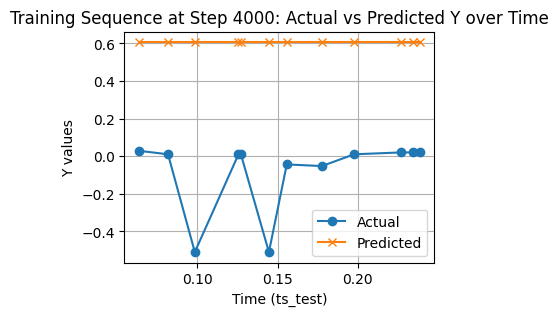

Step 4100, Loss: 11.9076, Best Loss: 0.0898, Estimated Time Remaining: 49.18 minutes
Step 4200, Loss: 12.7522, Best Loss: 0.0898, Estimated Time Remaining: 48.87 minutes
Step 4300, Loss: 12.0475, Best Loss: 0.0898, Estimated Time Remaining: 48.85 minutes
Step 4400, Loss: 12.6924, Best Loss: 0.0898, Estimated Time Remaining: 49.07 minutes
Step 4500, Loss: 11.8060, Best Loss: 0.0898, Estimated Time Remaining: 48.79 minutes
Step 4600, Loss: 12.1924, Best Loss: 0.0898, Estimated Time Remaining: 48.72 minutes
Step 4700, Loss: 11.2738, Best Loss: 0.0898, Estimated Time Remaining: 50.94 minutes
Step 4800, Loss: 12.4798, Best Loss: 0.0898, Estimated Time Remaining: 51.88 minutes
Step 4900, Loss: 11.3274, Best Loss: 0.0898, Estimated Time Remaining: 49.10 minutes
Step 5000, Loss: 11.4133, Best Loss: 0.0898, Estimated Time Remaining: 49.21 minutes
[0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705
 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705]


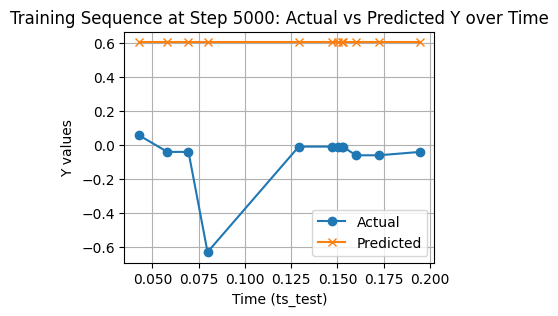

Step 5100, Loss: 12.2987, Best Loss: 0.0898, Estimated Time Remaining: 50.02 minutes
Step 5200, Loss: 12.6816, Best Loss: 0.0898, Estimated Time Remaining: 49.00 minutes
Step 5300, Loss: 11.1426, Best Loss: 0.0898, Estimated Time Remaining: 50.45 minutes
Step 5400, Loss: 11.6496, Best Loss: 0.0898, Estimated Time Remaining: 48.70 minutes
Step 5500, Loss: 11.9693, Best Loss: 0.0898, Estimated Time Remaining: 48.66 minutes
Step 5600, Loss: 12.1444, Best Loss: 0.0898, Estimated Time Remaining: 48.95 minutes
Step 5700, Loss: 11.2802, Best Loss: 0.0898, Estimated Time Remaining: 48.47 minutes
Step 5800, Loss: 12.2329, Best Loss: 0.0898, Estimated Time Remaining: 48.42 minutes
Step 5900, Loss: 11.6000, Best Loss: 0.0898, Estimated Time Remaining: 48.31 minutes
Step 6000, Loss: 12.3283, Best Loss: 0.0898, Estimated Time Remaining: 48.31 minutes
[0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705
 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705]


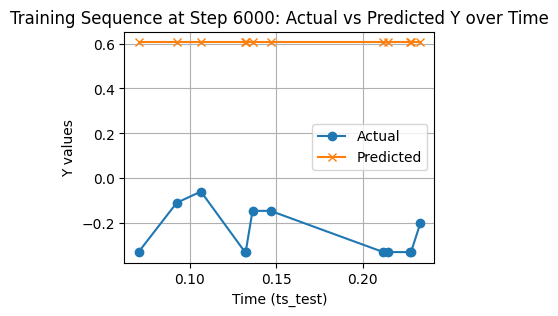

Step 6100, Loss: 13.0794, Best Loss: 0.0898, Estimated Time Remaining: 49.26 minutes
Step 6200, Loss: 11.2364, Best Loss: 0.0898, Estimated Time Remaining: 47.94 minutes
Step 6300, Loss: 10.8096, Best Loss: 0.0898, Estimated Time Remaining: 48.07 minutes
Step 6400, Loss: 10.6813, Best Loss: 0.0898, Estimated Time Remaining: 48.02 minutes
Step 6500, Loss: 11.8434, Best Loss: 0.0898, Estimated Time Remaining: 47.78 minutes
Step 6600, Loss: 11.7653, Best Loss: 0.0898, Estimated Time Remaining: 49.10 minutes
Step 6700, Loss: 11.0882, Best Loss: 0.0898, Estimated Time Remaining: 47.92 minutes
Step 6800, Loss: 10.6466, Best Loss: 0.0898, Estimated Time Remaining: 47.75 minutes
Step 6900, Loss: 10.4871, Best Loss: 0.0898, Estimated Time Remaining: 47.83 minutes
Step 7000, Loss: 10.1140, Best Loss: 0.0898, Estimated Time Remaining: 47.87 minutes
[0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705
 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705]


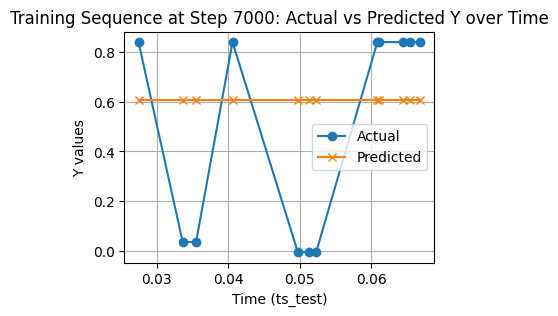

Step 7100, Loss: 10.7456, Best Loss: 0.0898, Estimated Time Remaining: 47.75 minutes
Step 7200, Loss: 10.5826, Best Loss: 0.0898, Estimated Time Remaining: 48.60 minutes
Step 7300, Loss: 10.1038, Best Loss: 0.0898, Estimated Time Remaining: 47.53 minutes
Step 7400, Loss: 9.6396, Best Loss: 0.0898, Estimated Time Remaining: 47.40 minutes
Step 7500, Loss: 10.7293, Best Loss: 0.0898, Estimated Time Remaining: 47.68 minutes
Step 7600, Loss: 9.1434, Best Loss: 0.0898, Estimated Time Remaining: 47.94 minutes
Step 7700, Loss: 9.5712, Best Loss: 0.0898, Estimated Time Remaining: 48.88 minutes
Step 7800, Loss: 9.2589, Best Loss: 0.0898, Estimated Time Remaining: 48.95 minutes
Step 7900, Loss: 11.3365, Best Loss: 0.0898, Estimated Time Remaining: 48.30 minutes
Step 8000, Loss: 9.7947, Best Loss: 0.0898, Estimated Time Remaining: 47.70 minutes
[0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705
 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705]


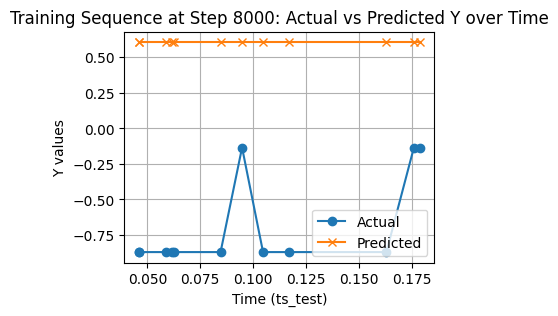

Step 8100, Loss: 9.7166, Best Loss: 0.0898, Estimated Time Remaining: 48.81 minutes
Step 8200, Loss: 9.4762, Best Loss: 0.0898, Estimated Time Remaining: 47.61 minutes
Step 8300, Loss: 9.5595, Best Loss: 0.0898, Estimated Time Remaining: 48.36 minutes
Step 8400, Loss: 8.5984, Best Loss: 0.0898, Estimated Time Remaining: 47.40 minutes
Step 8500, Loss: 8.9131, Best Loss: 0.0898, Estimated Time Remaining: 47.30 minutes
Step 8600, Loss: 8.5160, Best Loss: 0.0898, Estimated Time Remaining: 47.07 minutes
Step 8700, Loss: 8.1802, Best Loss: 0.0898, Estimated Time Remaining: 47.81 minutes
Step 8800, Loss: 8.1556, Best Loss: 0.0898, Estimated Time Remaining: 47.07 minutes
Step 8900, Loss: 8.6729, Best Loss: 0.0898, Estimated Time Remaining: 47.11 minutes
Step 9000, Loss: 8.2527, Best Loss: 0.0898, Estimated Time Remaining: 46.88 minutes
[0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705
 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705]


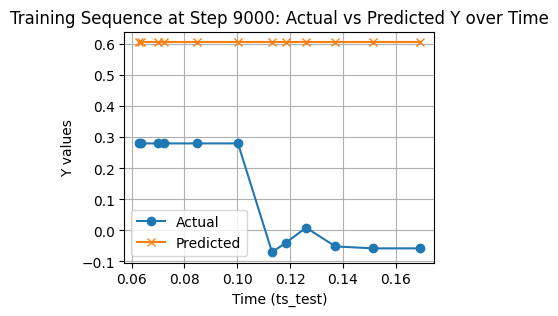

Step 9100, Loss: 7.0478, Best Loss: 0.0898, Estimated Time Remaining: 46.84 minutes
Step 9200, Loss: 7.2667, Best Loss: 0.0898, Estimated Time Remaining: 47.75 minutes
Step 9300, Loss: 7.5350, Best Loss: 0.0898, Estimated Time Remaining: 46.69 minutes
Step 9400, Loss: 7.1465, Best Loss: 0.0898, Estimated Time Remaining: 46.63 minutes
Step 9500, Loss: 6.8654, Best Loss: 0.0898, Estimated Time Remaining: 47.47 minutes
Step 9600, Loss: 6.7409, Best Loss: 0.0898, Estimated Time Remaining: 46.53 minutes
Step 9700, Loss: 5.6584, Best Loss: 0.0898, Estimated Time Remaining: 46.45 minutes
Step 9800, Loss: 6.1738, Best Loss: 0.0898, Estimated Time Remaining: 46.62 minutes
Step 9900, Loss: 6.0294, Best Loss: 0.0898, Estimated Time Remaining: 49.70 minutes
Step 10000, Loss: 6.7716, Best Loss: 0.0898, Estimated Time Remaining: 56.86 minutes
[0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705
 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705]


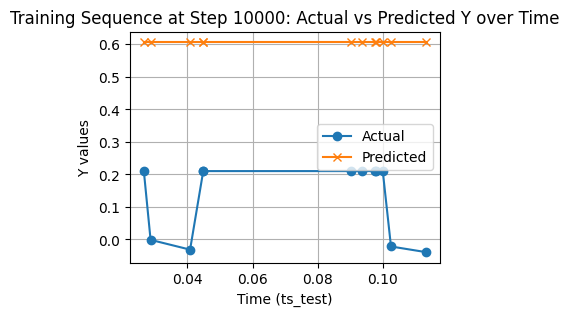

Step 10100, Loss: 5.6671, Best Loss: 0.0898, Estimated Time Remaining: 50.37 minutes
Step 10200, Loss: 5.1131, Best Loss: 0.0898, Estimated Time Remaining: 49.13 minutes
Step 10300, Loss: 5.6722, Best Loss: 0.0898, Estimated Time Remaining: 46.01 minutes
Step 10400, Loss: 5.8274, Best Loss: 0.0898, Estimated Time Remaining: 48.48 minutes
Step 10500, Loss: 4.7709, Best Loss: 0.0898, Estimated Time Remaining: 49.06 minutes
Step 10600, Loss: 4.2088, Best Loss: 0.0898, Estimated Time Remaining: 47.04 minutes
Step 10700, Loss: 4.4186, Best Loss: 0.0898, Estimated Time Remaining: 47.76 minutes
Step 10800, Loss: 3.9704, Best Loss: 0.0898, Estimated Time Remaining: 46.38 minutes
Step 10900, Loss: 3.4913, Best Loss: 0.0898, Estimated Time Remaining: 45.28 minutes
Step 11000, Loss: 4.7404, Best Loss: 0.0898, Estimated Time Remaining: 45.26 minutes
[0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705
 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705]


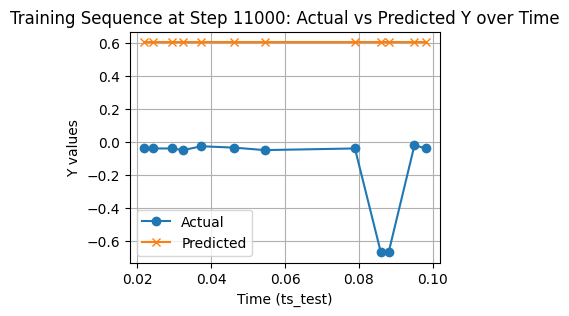

Step 11100, Loss: 3.6059, Best Loss: 0.0898, Estimated Time Remaining: 46.31 minutes
Step 11200, Loss: 3.5114, Best Loss: 0.0898, Estimated Time Remaining: 50.51 minutes
Step 11300, Loss: 2.5756, Best Loss: 0.0898, Estimated Time Remaining: 49.81 minutes
Step 11400, Loss: 2.6598, Best Loss: 0.0898, Estimated Time Remaining: 48.24 minutes
Step 11500, Loss: 2.4985, Best Loss: 0.0898, Estimated Time Remaining: 45.77 minutes
Step 11600, Loss: 2.4273, Best Loss: 0.0898, Estimated Time Remaining: 45.91 minutes
Step 11700, Loss: 1.8475, Best Loss: 0.0898, Estimated Time Remaining: 46.81 minutes
Step 11800, Loss: 2.7310, Best Loss: 0.0898, Estimated Time Remaining: 45.49 minutes
Step 11900, Loss: 1.9874, Best Loss: 0.0898, Estimated Time Remaining: 46.70 minutes
Step 12000, Loss: 1.4068, Best Loss: 0.0898, Estimated Time Remaining: 46.50 minutes
[0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705
 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705]


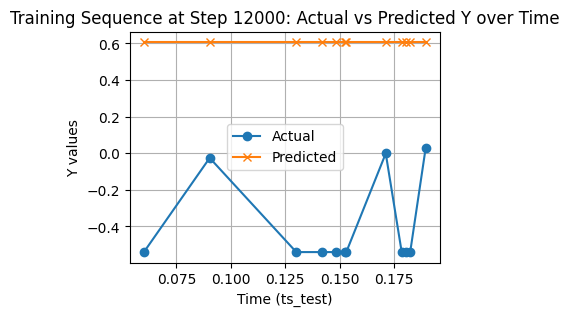

Step 12100, Loss: 1.4821, Best Loss: 0.0898, Estimated Time Remaining: 46.09 minutes
Step 12200, Loss: 1.4222, Best Loss: 0.0898, Estimated Time Remaining: 50.21 minutes
Step 12300, Loss: 1.5436, Best Loss: 0.0898, Estimated Time Remaining: 46.63 minutes
Step 12400, Loss: 0.9407, Best Loss: 0.0898, Estimated Time Remaining: 45.26 minutes
Step 12500, Loss: 0.8768, Best Loss: 0.0898, Estimated Time Remaining: 44.57 minutes
Step 12600, Loss: 0.9576, Best Loss: 0.0898, Estimated Time Remaining: 43.77 minutes
Step 12700, Loss: 0.5890, Best Loss: 0.0898, Estimated Time Remaining: 47.64 minutes
Step 12800, Loss: 0.6440, Best Loss: 0.0898, Estimated Time Remaining: 45.59 minutes
Step 12900, Loss: 0.8139, Best Loss: 0.0898, Estimated Time Remaining: 45.73 minutes
Step 13000, Loss: 0.3885, Best Loss: 0.0898, Estimated Time Remaining: 45.63 minutes
[0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705
 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705 0.60658705]


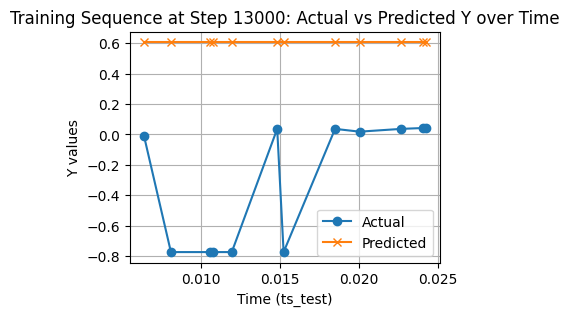

Step 13100, Loss: 0.4117, Best Loss: 0.0898, Estimated Time Remaining: 44.21 minutes
Step 13200, Loss: 0.3694, Best Loss: 0.0898, Estimated Time Remaining: 44.47 minutes
Step 13300, Loss: 0.3334, Best Loss: 0.0898, Estimated Time Remaining: 43.55 minutes
Step 13400, Loss: 0.2675, Best Loss: 0.0898, Estimated Time Remaining: 43.58 minutes
Step 13500, Loss: 0.4306, Best Loss: 0.0898, Estimated Time Remaining: 46.10 minutes
Step 13600, Loss: 0.0999, Best Loss: 0.0819, Estimated Time Remaining: 45.03 minutes
Step 13700, Loss: 0.2120, Best Loss: 0.0540, Estimated Time Remaining: 56.06 minutes
Step 13800, Loss: 0.4222, Best Loss: 0.0540, Estimated Time Remaining: 63.62 minutes
Step 13900, Loss: 0.1802, Best Loss: 0.0540, Estimated Time Remaining: 64.20 minutes
Step 14000, Loss: 0.3153, Best Loss: 0.0540, Estimated Time Remaining: 48.16 minutes
[0.14557388 0.14557388 0.14557388 0.14557388 0.14557388 0.14557388
 0.14557388 0.14557388 0.14557388 0.14557388 0.14557388 0.14557388]


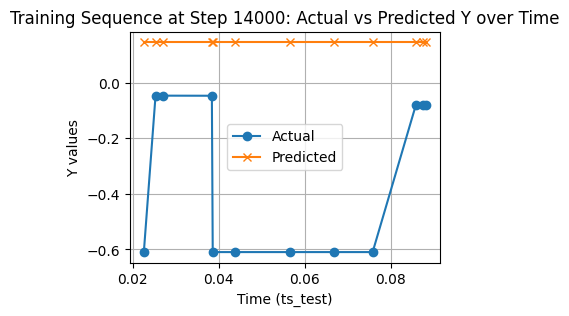

Step 14100, Loss: 0.5240, Best Loss: 0.0540, Estimated Time Remaining: 48.87 minutes
Step 14200, Loss: 0.2153, Best Loss: 0.0534, Estimated Time Remaining: 46.93 minutes
Step 14300, Loss: 0.1311, Best Loss: 0.0418, Estimated Time Remaining: 46.53 minutes
Step 14400, Loss: 0.1288, Best Loss: 0.0374, Estimated Time Remaining: 45.16 minutes
Step 14500, Loss: 0.1216, Best Loss: 0.0374, Estimated Time Remaining: 47.56 minutes
Step 14600, Loss: 0.0813, Best Loss: 0.0374, Estimated Time Remaining: 43.72 minutes
Step 14700, Loss: 0.1040, Best Loss: 0.0374, Estimated Time Remaining: 48.41 minutes
Step 14800, Loss: 0.2413, Best Loss: 0.0374, Estimated Time Remaining: 45.10 minutes
Step 14900, Loss: 0.1190, Best Loss: 0.0374, Estimated Time Remaining: 45.78 minutes
Step 15000, Loss: 0.1047, Best Loss: 0.0372, Estimated Time Remaining: 47.97 minutes
[-0.13045828 -0.13045828 -0.13045828 -0.13045828 -0.13045828 -0.13045828
 -0.13045828 -0.13045828 -0.13045828 -0.13045828 -0.13045828 -0.13045828]


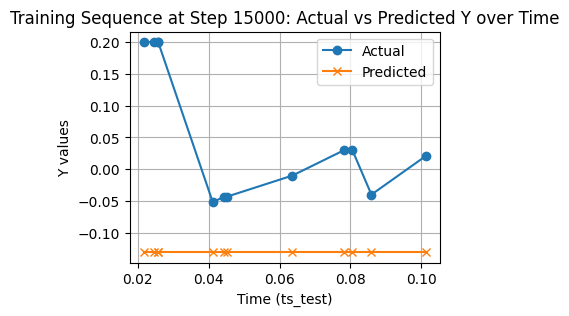

Step 15100, Loss: 0.1143, Best Loss: 0.0372, Estimated Time Remaining: 44.33 minutes
Step 15200, Loss: 0.0954, Best Loss: 0.0372, Estimated Time Remaining: 43.46 minutes
Step 15300, Loss: 0.1853, Best Loss: 0.0372, Estimated Time Remaining: 43.84 minutes
Step 15400, Loss: 0.1390, Best Loss: 0.0372, Estimated Time Remaining: 44.45 minutes
Step 15500, Loss: 0.1418, Best Loss: 0.0372, Estimated Time Remaining: 43.58 minutes
Step 15600, Loss: 0.2414, Best Loss: 0.0372, Estimated Time Remaining: 44.24 minutes
Step 15700, Loss: 0.0806, Best Loss: 0.0372, Estimated Time Remaining: 44.55 minutes
Step 15800, Loss: 0.3075, Best Loss: 0.0372, Estimated Time Remaining: 46.15 minutes
Step 15900, Loss: 0.2117, Best Loss: 0.0372, Estimated Time Remaining: 51.36 minutes


KeyboardInterrupt: 

In [310]:
data_size = 6
hidden_size = 4
width_size = 8
depth = 3

model = NeuralCDE(data_size, hidden_size, width_size, depth, key=key())

eta = 1
optimizer = optax.adam(learning_rate=eta)

steps = 100_000
batch_size = 8
seq_length = 64
eval_point_ratio = 12/64
subset_size = 1024

trained_model = train(
    model,
    data,
    optimizer,
    steps,
    batch_size,
    seq_length, 
    eval_point_ratio, 
    key(), 
    subset_size,
    plot_every=1000,
    patience=25_000,
)